In [8]:
import numpy as np, pandas as pd, gc
from sklearn.datasets import fetch_california_housing    # ← NEW
from sklearn import preprocessing
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import scipy
import itertools

# import code
import code.methods as methods  

import matplotlib
matplotlib.use('TkAgg')  # or 'Qt5Agg' if you have PyQt5
%matplotlib inline
import matplotlib.pyplot as plt



def r_squared(y_test, pred, y_train):
    return 1 - np.sum((y_test - pred)**2) / np.sum((y_test - np.mean(y_train))**2)

# --------------------
# 1. Load the data
# --------------------
seed = 10
np.random.seed(seed)

cal = fetch_california_housing(as_frame=True)
X, y = cal.data, cal.target
print("California Housing (sklearn)")
print(f"{len(X)} rows")
print(f"{X.shape[1]} columns")

# --------------------
# 2. Train / test split + scaling
# --------------------
xTrain, xTest, yTrain, yTest = train_test_split(
    X, y, test_size=0.3, random_state=seed
)
scaler_X = preprocessing.StandardScaler()
xTrain   = pd.DataFrame(scaler_X.fit_transform(xTrain),
                        columns=X.columns, index=xTrain.index)
xTest    = pd.DataFrame(scaler_X.transform(xTest),
                        columns=X.columns, index=xTest.index)

scaler_y = preprocessing.StandardScaler()
yTrain   = pd.Series(scaler_y.fit_transform(yTrain.values.reshape(-1,1)).ravel(),
                     index=xTrain.index)
yTest    = pd.Series(scaler_y.transform(yTest.values.reshape(-1,1)).ravel(),
                     index=xTest.index)

# --------------------
# 3. Fit random-forest models
# --------------------
n_estimators, max_depth = 100, 5

rf = RandomForestRegressor(
    n_estimators=n_estimators, max_features="sqrt",
    max_depth=max_depth, random_state=seed
).fit(xTrain, yTrain)

print("R² rf (max_depth=5):",
      r_squared(yTest, rf.predict(xTest), yTrain))



# --------------------
# 4. Clean up if you need the scaled training data later
# --------------------
del X, y
X = xTrain.copy()
y = yTrain.values
tree_list = rf.estimators_

gc.collect()



California Housing (sklearn)
20640 rows
8 columns
R² rf (max_depth=5): 0.6289710518897778


44

# Compute Regularization Path

In [16]:
#Our Method
lambda_penalized_range = np.flip(np.logspace(1,4,25))
cbcd_tol = 10**-3
lambda_ridge = 0.01

In [17]:
M_all,c_all, depths_ensemble, n_obs_ensemble, n_nodes_ensemble,blocks \
                = methods.get_ensemble_details(xTrain.values, tree_list)
M_test_all = []
for tree1 in tree_list:
    M_test_all.append(tree1.decision_path(xTest).tocsc())
M_test_ensemble = scipy.sparse.hstack(M_test_all, format='csc')

/Users/bliu1/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:2742: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
/Users/bliu1/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:2742: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
/Users/bliu1/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:2742: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
/Users/bliu1/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:2742: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
/Users/bliu1/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:2742: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
/Users/bliu1/anacond

In [18]:
w_res, z_res, solves, losses =  methods.CBCD_path_preload(lambda_penalized_range, yTrain.values, M_all,c_all,blocks, lambda_ridge , a_array = [],
                                                  warm_start = True, debias = False,  ILP_tol = 0.001, cbcd_tol = cbcd_tol, early_stop_support = 60)


/Users/bliu1/Downloads/TreeExtract-main/code/methods.py:746: SparseEfficiencyWarning: splu converted its input to CSC format
  LU = splu(I_lambda + XtX)


0.7300658226013184 10000.0
0.6581802368164062 7498.942093324558
0.9368629455566406 5623.413251903491
1.0957787036895752 4216.965034285822
1.3805150985717773 3162.2776601683795
2.1398327350616455 2371.373705661655
2.3448328971862793 1778.2794100389228
1.9584169387817383 1333.521432163324
2.325684070587158 1000.0
1.5970239639282227 749.8942093324558
2.3314270973205566 562.341325190349
5.437523126602173 421.6965034285823
1.8708088397979736 316.22776601683796
2.780580759048462 237.13737056616552
3.6654839515686035 177.82794100389228
2.7122559547424316 133.3521432163324
4.8447887897491455 100.0
5.878940105438232 74.98942093324558
2.6654937267303467 56.23413251903491
4.082124948501587 42.169650342858226
5.383404016494751 31.622776601683793
7.258832216262817 23.71373705661655
7.165898084640503 17.78279410038923
6.472866058349609 13.33521432163324
13.543009042739868 10.0


In [19]:
res_path1 = []
ind1 = 0
for counter in range(len(z_res)):
    z_array = z_res[counter]
    w_array = w_res[counter]
    pred_test = methods.get_pred(M_test_all, z_array, w_array)
    nonzeros = sum(list(itertools.chain.from_iterable(z_array)))
    r2 = r_squared(yTest,pred_test,yTrain.values)
    res_path1.append([ind1,nonzeros,r2])
    ind1 =ind1 + 1
res_path1 = np.array(res_path1)

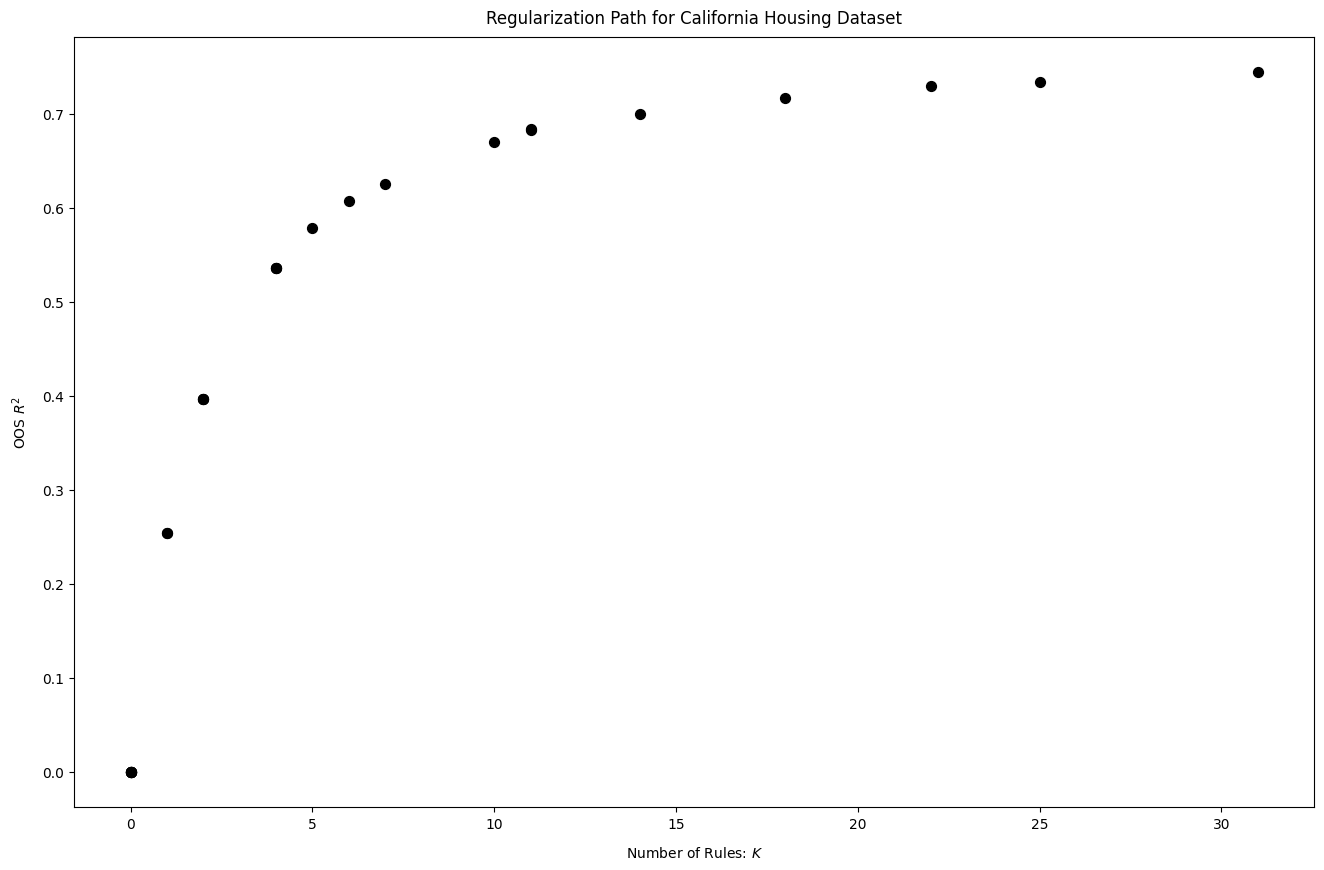

In [20]:
plt.figure(figsize = (16,10))
plt.scatter(res_path1[:,1],res_path1[:,2],alpha = 1, s = 50, color = 'black')
plt.xlabel('Number of Rules: $K$',labelpad = 10)
plt.ylabel('OOS $R^2$', labelpad = 10 )
plt.title('Regularization Path for California Housing Dataset',pad = 10)
plt.show()